The following model is the standard GAN which is part of **Exercise 1**. It is a very simple example and you can improve it by adding convolutions and many other ideas that we talked about if you want. Fill in the missing pieces and train it.


In [14]:
 import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [10]:


os.makedirs("images", exist_ok=True)
      
n_epochs = 50         #number of epochs of training
batch_size = 64       #size of the batches
lr = 0.0002           #adam: learning rate
b1 = 0.5              #adam: decay of first order momentum of gradient
b2 = 0.999            #adam: decay of second order momentum of gradient
n_cpu = 8,            #number of cpu threads to use during batch generation
latent_dim = 100      #dimensionality of the latent space
img_size = 28         #size of each image dimension
channels = 1          #number of image channels
sample_interval = 400 #interval between image samples


img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

random_seed = 1
torch.manual_seed(random_seed)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
# Define your loss as Cross Entropy
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

def maybe_cuda(x):
  if cuda:
    return x.cuda()
  return x

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        # We use the Cross Entropy (CE) loss. So we need labels. Define them here:
        real_labels = maybe_cuda(torch.ones(imgs.shape[0], 1))
        fake_labels = maybe_cuda(torch.zeros(imgs.shape[0], 1))


        # Configure input
        real_imgs = maybe_cuda(imgs)  # input the real samples

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = maybe_cuda(torch.randn(real_imgs.shape[0], latent_dim))  # sample z from a standard gaussian

        # Generate a batch of images
        gen_imgs = generator(z)  # create generated images
        
        # Loss measures generator's ability to fool the discriminator
        # log(1 - discriminator(gen_imgs))
        d_gen_imgs = discriminator(gen_imgs)
        g_loss = -adversarial_loss(d_gen_imgs, fake_labels)  # think about how to use the CE loss here

        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        d_real_imgs = discriminator(real_imgs)
        real_loss = adversarial_loss(d_real_imgs, real_labels)  # define loss
        gen_imgs = generator(z)
        d_gen_imgs = discriminator(gen_imgs)
        fake_loss = adversarial_loss(d_gen_imgs, fake_labels)  # define loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        if i%200 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch+1, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # You can also safe samples in your drive & maybe save your network as well
            save_image(gen_imgs.data[:25], "images/GAN-%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 1/50] [Batch 0/938] [D loss: 0.719070] [G loss: -0.666384]
[Epoch 1/50] [Batch 200/938] [D loss: 0.620432] [G loss: -0.522527]
[Epoch 1/50] [Batch 400/938] [D loss: 0.539898] [G loss: -0.490950]
[Epoch 1/50] [Batch 600/938] [D loss: 0.465138] [G loss: -0.222982]
[Epoch 1/50] [Batch 800/938] [D loss: 0.358302] [G loss: -0.273690]
[Epoch 2/50] [Batch 0/938] [D loss: 0.647607] [G loss: -0.116920]
[Epoch 2/50] [Batch 200/938] [D loss: 0.276954] [G loss: -0.129999]
[Epoch 2/50] [Batch 400/938] [D loss: 0.363075] [G loss: -0.360594]
[Epoch 2/50] [Batch 600/938] [D loss: 0.395367] [G loss: -0.259472]
[Epoch 2/50] [Batch 800/938] [D loss: 0.484017] [G loss: -0.264310]
[Epoch 3/50] [Batch 0/938] [D loss: 0.363125] [G loss: -0.086154]
[Epoch 3/50] [Batch 200/938] [D loss: 0.316924] [G loss: -0.282790]
[Epoch 3/50] [Batch 400/938] [D loss: 0.265962] [G loss: -0.182572]
[Epoch 3/50] [Batch 600/938] [D loss: 0.329412] [G loss: -0.165280]
[Epoch 3/50] [Batch 800/938] [D loss: 0.328490] [G los

In [12]:
torch.manual_seed(42)
example_z = maybe_cuda(torch.randn(10, latent_dim))
example_gen = generator(example_z)

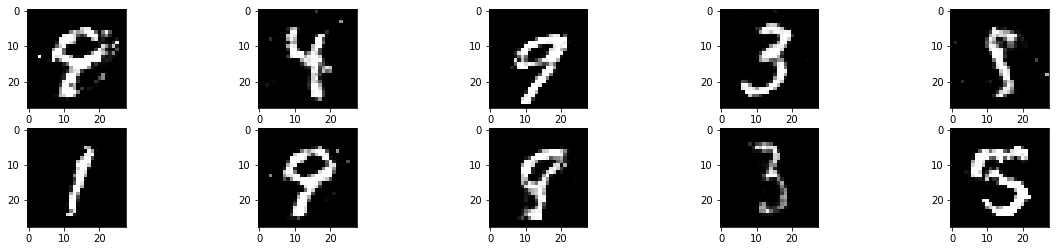

In [20]:
plt.figure(figsize=(20, 4))
imshow_shape = img_shape[1:] + img_shape[:1]
if imshow_shape[-1] == 1:
  imshow_shape = imshow_shape[:2]
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(example_gen[i].cpu().detach().reshape(*imshow_shape), cmap='gray')

In [23]:
from collections import Counter
from functools import wraps, partial


def collect_after(c):
  def decorator(f):
    @wraps(f)
    def g(*args, **kwargs):
      return c(f(*args, **kwargs))
    return g
  return decorator


class KNearestNeighbors():
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2, axis=1):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1 - x_2) ** 2, axis=axis)
    
    def set_k(self, k):
      self.k = k
    
    def __init__(self, k=3):
      self.set_k(k)
    
    def fit(self, X, y):
      self.X = X
      self.y = y
    
    @collect_after(tuple)
    def calculate_nearest(self, X, k=None):
      if k is None:
        k = self.k
      for obj in X:
        nearest = []
        for i, known in enumerate(self.X):
          d = self.squared_euclidean_distance(known, obj, axis=0)
          nearest.append((d, i))
          nearest.sort()
          nearest[k:] = []
        yield tuple(nearest)
    
    @collect_after(partial(np.fromiter, dtype=float))
    def predict_class(self, X, nearest=None):
      res = []
      k = self.k
      if nearest is None:
        nearest = self.calculate_nearest(X, k)
      for nearest_current in nearest:
        yield Counter(self.y[i] for _, i in nearest_current[:k]).most_common(1)[0][0]
    
    def predict_class_different_k(self, X, ks=(3,)):
      ks = tuple(ks)
      nearest = self.calculate_nearest(X, max(ks))
      for k in ks:
        self.set_k(k)
        yield (k, self.predict_class(X, nearest=nearest))


def accuracy(y_actual, y_pred):
  return (y_actual == y_pred).sum() / len(y_actual) 

In [30]:
dataset_train = datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    )
X_train, y_train = next(iter(DataLoader(dataset_train, len(dataset_train))))
X_train = X_train.reshape(X_train.shape[0], -1).numpy()
y_train = y_train.numpy()

In [29]:
 dataset_test = datasets.MNIST(
        "../../data/mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    )
X_test, y_test = next(iter(DataLoader(dataset_test, len(dataset_test))))
X_test = X_test.reshape(X_test.shape[0], -1).numpy()
y_test = y_test.numpy()

In [34]:
%%time
knn_model = KNearestNeighbors()
knn_model.fit(X_train[::12], y_train[::12])
y_pred = knn_model.predict_class(X_test[::100])
print(accuracy(y_test[::100], y_pred))

0.92
CPU times: user 3.85 s, sys: 2 ms, total: 3.85 s
Wall time: 3.85 s


In [38]:
%%time
torch.manual_seed(42)
z = maybe_cuda(torch.randn(1000, latent_dim))
gen_img = generator(z).cpu().detach().reshape(z.shape[0], -1).numpy()

CPU times: user 7.18 ms, sys: 1 ms, total: 8.19 ms
Wall time: 9.82 ms


In [43]:
%%time
gen_img_classes = knn_model.predict_class(gen_img)

CPU times: user 38.6 s, sys: 13.6 ms, total: 38.6 s
Wall time: 38.6 s


(array([ 90., 194.,  52.,  93.,  96.,  55.,  90., 127.,  76., 127.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

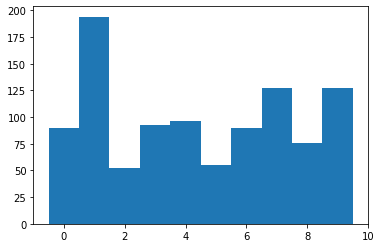

In [49]:
plt.hist(gen_img_classes, bins=np.array(list(range(11))) - .5)

In [67]:
 class CGenerator(nn.Module):
    def __init__(self, y_len):
        super(CGenerator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + y_len, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z, y):
        img = self.model(torch.cat((z, y), 1))
        img = img.view(img.size(0), *img_shape)
        return img


class CDiscriminator(nn.Module):
    def __init__(self, y_len):
        super(CDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape) + y_len), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, y):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(torch.cat((img_flat, y), 1))

        return validity

In [75]:
%%time
torch.manual_seed(random_seed)
cgenerator = maybe_cuda(CGenerator(1))
cdiscriminator = maybe_cuda(CDiscriminator(1))
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_CG = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(b1, b2))
optimizer_CD = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(b1, b2))

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, real_y) in enumerate(dataloader):

        # Adversarial ground truths
        # We use the Cross Entropy (CE) loss. So we need labels. Define them here:
        real_labels = maybe_cuda(torch.ones(imgs.shape[0], 1))
        fake_labels = maybe_cuda(torch.zeros(imgs.shape[0], 1))


        # Configure input
        real_imgs = maybe_cuda(imgs)  # input the real samples
        real_y = maybe_cuda(real_y.reshape(-1, 1))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_CG.zero_grad()

        # Sample noise as generator input
        z = maybe_cuda(torch.randn(real_imgs.shape[0], latent_dim))  # sample z from a standard gaussian
        fake_y = maybe_cuda(torch.randint(0, 10, (real_imgs.shape[0], 1)))  # is there a better way?

        # Generate a batch of images
        gen_imgs = cgenerator(z, fake_y)  # create generated images
        
        # Loss measures generator's ability to fool the discriminator
        # log(1 - discriminator(gen_imgs))
        d_gen_imgs = cdiscriminator(gen_imgs, fake_y)
        g_loss = -adversarial_loss(d_gen_imgs, fake_labels)  # think about how to use the CE loss here

        g_loss.backward()
        optimizer_CG.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_CD.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        d_real_imgs = cdiscriminator(real_imgs, real_y)
        real_loss = adversarial_loss(d_real_imgs, real_labels)  # define loss
        #gen_imgs = cgenerator(z, fake_y).detach()
        gen_imgs = cgenerator(z, fake_y)
        d_gen_imgs = cdiscriminator(gen_imgs, fake_y)
        fake_loss = adversarial_loss(d_gen_imgs, fake_labels)  # define loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_CD.step()
        if i%200 == 0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch+1, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # You can also safe samples in your drive & maybe save your network as well
            save_image(gen_imgs.data[:25], "images/CGAN-%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 1/50] [Batch 0/938] [D loss: 0.705842] [G loss: -0.690002]
[Epoch 1/50] [Batch 200/938] [D loss: 0.549300] [G loss: -0.594692]
[Epoch 1/50] [Batch 400/938] [D loss: 0.472197] [G loss: -0.315305]
[Epoch 1/50] [Batch 600/938] [D loss: 0.341053] [G loss: -0.295353]
[Epoch 1/50] [Batch 800/938] [D loss: 0.430473] [G loss: -0.250295]
[Epoch 2/50] [Batch 0/938] [D loss: 0.699149] [G loss: -0.592636]
[Epoch 2/50] [Batch 200/938] [D loss: 0.381761] [G loss: -0.303871]
[Epoch 2/50] [Batch 400/938] [D loss: 0.392030] [G loss: -0.334732]
[Epoch 2/50] [Batch 600/938] [D loss: 0.340351] [G loss: -0.079854]
[Epoch 2/50] [Batch 800/938] [D loss: 0.503274] [G loss: -0.469074]
[Epoch 3/50] [Batch 0/938] [D loss: 0.530194] [G loss: -0.049962]
[Epoch 3/50] [Batch 200/938] [D loss: 0.317677] [G loss: -0.308035]
[Epoch 3/50] [Batch 400/938] [D loss: 0.430354] [G loss: -0.413808]
[Epoch 3/50] [Batch 600/938] [D loss: 0.321960] [G loss: -0.129277]
[Epoch 3/50] [Batch 800/938] [D loss: 0.365198] [G los

In [76]:
torch.manual_seed(42)
cexample_z = maybe_cuda(torch.randn(10, latent_dim))
cexample_y = maybe_cuda(torch.randint(0, 10, (10, 1)))
cexample_gen = cgenerator(cexample_z, cexample_y)

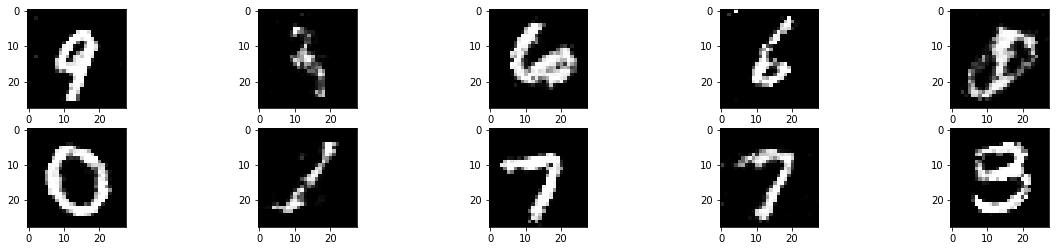

In [77]:
plt.figure(figsize=(20, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(cexample_gen[i].cpu().detach().reshape(*imshow_shape), cmap='gray')